In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import math
from scipy import signal
from scipy.fftpack import fft
from scipy import ndimage
%matplotlib inline


In [2]:
def K(x,s):
    return (np.exp(-(x/s)**2))/(s*np.sqrt(np.pi))

In [3]:
def PIfunc(r, x, v, dt, window):
    negshift=window[0] # second
    posshift=window[1] # second
    shiftlen=(posshift-negshift)/dt+1
    timeshift=np.linspace(negshift,posshift,int(shiftlen))
    bitshift=np.linspace(negshift/dt,posshift/dt,int(shiftlen),dtype = 'int16')
    Information = dict()
    Information[('BROJA_2PID','SI')]=np.zeros(len(bitshift))
    Information[('BROJA_2PID','UIx')]=np.zeros(len(bitshift))
    Information[('BROJA_2PID','UIv')]=np.zeros(len(bitshift))
    Information[('BROJA_2PID','CI')]=np.zeros(len(bitshift))
    Information[('Beer','Red')]=np.zeros(len(bitshift))
    Information[('Beer','UIx')]=np.zeros(len(bitshift))
    Information[('Beer','UIv')]=np.zeros(len(bitshift))
    Information[('Beer','Syn')]=np.zeros(len(bitshift))
    
    Information[('test','SI')]=np.zeros(len(bitshift))
    Information[('test','UIx')]=np.zeros(len(bitshift))
    Information[('test','UIv')]=np.zeros(len(bitshift))
    Information[('test','CI')]=np.zeros(len(bitshift))
    # shifted data
    # shift>0 => y shifted to positive side
    for i in range(len(bitshift)):
        xx=[]
        vv=[]
        rr=[]
        shift=bitshift[i]
        if shift>0:
            xx=x[shift:]
            vv=v[shift:]
            rr=r[:(-1*shift)]
        elif shift==0:
            xx=x
            vv=v
            rr=r
        elif shift<0:
            xx=x[:shift]
            vv=v[:shift]
            rr=r[(-1*shift):]
        #find weight of each states by 3D histogram 
        xedges = np.append(np.unique(xx),(max(xx)+1))
        vedges = np.append(np.unique(vv),(max(vv)+1))
        redges = np.append(np.unique(rr),(max(rr)+1))
        dat = np.concatenate((xx[:,np.newaxis], vv[:,np.newaxis],rr[:,np.newaxis]), axis=1)
        N, edges = np.histogramdd(dat, bins=(xedges, vedges, redges))
        #Calculate all kinds of probability and make sure the shape of them, 0 -> x, 1 -> v, 2 -> r
        px=(np.sum(N,axis=(1,2))/np.sum(N))[:, np.newaxis, np.newaxis]
        pv=(np.sum(N,axis=(0,2))/np.sum(N))[np.newaxis, :, np.newaxis]
        pr=(np.sum(N,axis=(0,1))/np.sum(N))[np.newaxis ,np.newaxis, :]
        pxv=(np.sum(N,axis=2)/np.sum(N))[:, :, np.newaxis]
        pxr=(np.sum(N,axis=1)/np.sum(N))[:, np.newaxis, :]
        pvr=(np.sum(N,axis=0)/np.sum(N))[np.newaxis, :, :]
        pxvr=(N/np.sum(N))
        
        Information[('test','UIx')][i] = np.nansum(pxvr*np.log2(pxvr*px/pxv/pxr))/dt
        Information[('test','UIv')][i] = np.nansum(pxvr*np.log2(pxvr*pv/pxv/pvr))/dt


        MIxr=np.nansum(pxr*np.log2(pxr/px/pr))/dt
        MIvr=np.nansum(pvr*np.log2(pvr/pv/pr))/dt
        MIxvR=np.nansum(pxvr*np.log2(pxvr/pxv/pr))/dt
        PI_xR = np.nansum(pxr*np.log2(pxr/px/pr), axis = (0,1))
        PI_vR = np.nansum(pvr*np.log2(pvr/pv/pr), axis = (0,1))
        R = sum(np.minimum(PI_xR, PI_vR))/dt
        Information[('Beer','Red')][i] = R
        Information[('Beer','UIx')][i] = MIxr - R
        Information[('Beer','UIv')][i] = MIvr - R
        Information[('Beer','Syn')][i] = MIxvR - MIxr - MIvr + R

    return timeshift, Information

In [4]:
# using numpy's histogram2d to calculate the mutual information between two sequences
def mi_quick(a,b,d,bn=25):
    if d>0: xy,_,_ = np.histogram2d(a[d:],b[:-d],bn)
    elif d<0: xy,_,_ = np.histogram2d(a[:d],b[-d:],bn)
    else: xy,_,_ = np.histogram2d(a,b,bn)
    xy /= np.sum(xy)
    px = [np.array([max(x,1e-100) for x in np.sum(xy,axis=0)])]
    py = np.transpose([[max(x,1e-100) for x in np.sum(xy,axis=1)]])
    nxy = (xy/px)/py
    nxy[nxy==0] = 1e-100
    return np.sum(xy*np.log2(nxy))

In [5]:
## EqualState assign states with equal possibility for input array x
def EqualState(x, num_state):
    xs=np.sort(x)
    binlen=int(len(x)/num_state-0.5) #round
    edges = xs[np.arange(num_state+1)*binlen]
    xstate=np.zeros(len(x))
    for i in range(num_state):
        xstate[x>=edges[i]] = i
    xstate = xstate.astype(int)
    return xstate, edges

In [6]:
# Guassian function with mean x0 and standard deviation sigma
def G(x,x0,sigma):
    y = np.exp(-((x-x0)/sigma)**2)
    return(y)

In [7]:
sigma_h = 1 # all 'dimention-L' parameters are narmalize by sigma_h
sigma_c = 0.5*sigma_h
sigma_g = 10.*sigma_c

dx = sigma_h/60.
xlen = 5000 #spatial 'step' of simulation
xaxis = np.arange(0, xlen)*dx

dis_h = sigma_h
dis_c = sigma_c
h_loc = np.zeros(xlen)
locx = np.arange(dis_h, xlen*dx-dx, dis_h)/dx
h_loc[np.round(locx).astype(int)] = 1
c_loc = np.zeros(xlen)
locx = np.arange(dis_c, xlen*dx-dx, dis_c)/dx
c_loc[np.round(locx).astype(int)] = 1

sum(h_loc)

83.0

In [8]:
klen = min(sigma_h*3, int(xlen*dx/2))
xx = np.arange(-klen,klen,dx)

KC = K(xx,sigma_c)
KH = K(xx,sigma_h)
KG = K(xx,sigma_g)

In [116]:
num = 10
alpha = 100.
beta = 1./1.5
k = 200.
phi = 1.
g = beta*50.

k*g*phi/alpha/beta,  beta*k/(alpha*beta+k*g*phi)

(99.99999999999999, 0.0198019801980198)

In [117]:
Tot=300
dt=0.01
T=np.arange(dt,Tot,dt)
# OU ; input
tau= 1
D = 27*10**5
OU=np.zeros(len(T))
mu, sigma = 0, 1
for i in range(len(T)-1):
    OU[i+1]=OU[i]*(1-dt/tau)+math.sqrt(D*dt)*np.random.normal(mu,sigma)
    
# filtering for OUSmoothed
cutoffFreq = 1
b, a = signal.butter(2, 2*cutoffFreq*dt, btype='low', analog=False)
LPOU = signal.filtfilt(b, a, OU)

In [118]:
pos_0 = 0
y = np.zeros(xlen) # cone cell output
z = np.zeros(xlen) # horizontal cell output
rz = np.zeros(xlen) # horizontal cell output
ry = np.convolve(y,KH,'same') # feedback from horizontal cell (y convoluted with horitonatl cell receptive field KH)
nstep = 5000

speak = LPOU[0:nstep]
rpeak = np.zeros(nstep)

stm = []
rsp = []
zts = []
tmp = []


for i in range(nstep):
    rs =  np.ones(xlen)*speak[i]

    dyj =(-alpha*y+k*(rs-rz))*dt
    y = (y+dyj)*c_loc
    dzj =(-beta*z+g*y)*dt
    z = (z+dzj)*h_loc
        
    rz = np.convolve(z,KH,'same') # feedback from horizontal cell (y convoluted with horitonatl cell receptive field KH)
    ry = np.convolve(y,KH,'same') # feedback from horizontal cell (y convoluted with horitonatl cell receptive field KH)

    
    
    output = np.convolve(y,KG,'same')*dx
    rpeak[i]= np.convolve(y,KG,'same')[2500]
    
    stm.append(rs.copy())
    rsp.append(y.copy())
    zts.append(z.copy())
    
#     if i%50 == 0:
#         #plt.plot(y[maxpos-50:maxpos+50])
#         plt.plot(xaxis, output)
#         tmp.append(output)


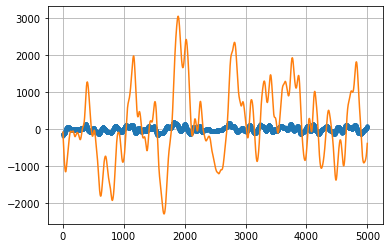

In [119]:
plt.plot(rpeak,'.')
plt.plot((speak))
plt.grid()

In [120]:
y = np.zeros(nstep)
z = np.zeros(nstep)
for i in range(nstep-1):
    dyj =(-alpha*y[i]+k*(speak[i]-z[i]))*dt
    y[i+1] = (y[i]+dyj)
    dzj =(-beta*z[i]+g*y[i])*dt
    z[i+1] = (z[i]+dzj)

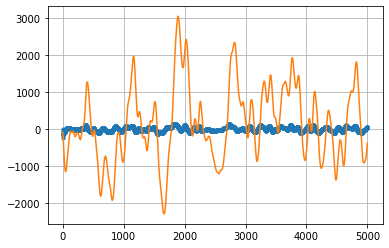

In [121]:
plt.plot(y,'.')
plt.plot((speak))
plt.grid()

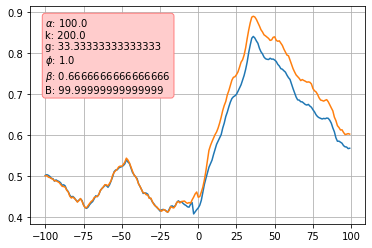

In [122]:
dms = range(-100,100)
mi_ss = [mi_quick(speak,y,d) for d in dms]
mi_sr = [mi_quick(speak,rpeak,d) for d in dms]
# mi_syy = [mi_quick(speak,nA(yy,20),d) for d in dms]
plt.plot(dms, mi_ss)
plt.plot(dms, mi_sr)
plt.grid()

text = r"$\alpha$: "+str(alpha)+'\nk: '+str(k)+'\ng: '+str(g)+'\n'+r'$\phi$: '+str(phi)+'\n'+r'$\beta$: '+str(beta)+'\nB: '+str(k*g*phi/alpha/beta)
plt.text(dms[0], max(mi_sr), text, va = 'top', bbox=dict(boxstyle="round",ec=(1., 0.5, 0.5),fc=(1., 0.8, 0.8),),  wrap=True)
figure = plt.gcf()

In [123]:
save_folder = 'C:\\Users\\hydro_leo\\Documents\\GitHub\\python-code\\analysis result\\DeltaT vs Tau\\'
# save_folder = 'C:\\Users\\llinc\\GitHub\\python code\\analysis result\\DeltaT vs Tau\\'
name = str(num)+'.tif'

figure.savefig('WF_test_fig\\'+name)